# CNN1 SETTINGS

In [15]:
import seaborn as sns
import pandas as pd
import numpy as np                
import warnings
import string
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale


contributor_selected = "II"                                 
contributor_train_file_path = '../data/Contributor_' + contributor_selected + '_Train.mat'
contributor_test_file_path = '../data/Contributor_' + contributor_selected + '_Test.mat'
channel_name_file_path = '../data/channels.csv'
channels = [i for i in range(64)]
warnings.filterwarnings('ignore')

# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [16]:
from scipy.io import loadmat
from scipy import signal
from bundle.DataCraft import * 

data_train = loadmat(contributor_train_file_path)
signals_train = data_train['Signal']
flashing_train = data_train['Flashing']
stimulus_train = data_train['StimulusType']
word_train = data_train['TargetChar']
sampling_frequency = 240
repetitions = 15
recording_duration_train = (len(signals_train)) * (len(signals_train[0])) / (sampling_frequency * 60)
trials_train = len(word_train[0])

print("Train Data:")
print_data(signals_train, word_train, contributor_selected, sampling_frequency)

Train Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
II              240.00               46.01                85         VGREAAH8TVRHBYN_UGCOLO4EUERDOO
                                                                     HCIFOMDNU6LQCPKEIREKOYRQIDJXPB
                                                                     KOJDWZEUEWWFOEBHXTQTTZUMO     


In [17]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_train):
    signals_train[trial, :, :] = signal.filtfilt(b, a, signals_train[trial, :, :], axis=0)
    
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_train[0])))

signals_train = signals_train[:, 0:-1:SCALE_FACTOR, :]
flashing_train = flashing_train[:, 0:-1:SCALE_FACTOR]
stimulus_train = stimulus_train[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_train[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [18]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals_train[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(trials_train):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing_train[trial, sample - 1] == 0 and flashing_train[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_train[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus_train[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 78)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

Features tensor shape: (15300, 78, 64)


# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [19]:
from bundle.DataCraft import *  

data_test = loadmat(contributor_test_file_path)
signals_test = data_test['Signal']
flashing_test = data_test['Flashing']
word_test =  data_test['TargetChar']
stimulus_code_test = data_test['StimulusCode']
sampling_frequency = 240
repetitions = 15
recording_duration_test = (len(signals_test)) * (len(signals_test[0])) / (sampling_frequency * 60)
trials_test = len(word_test[0])
samples_per_trial_test = len(signals_test[0])

print("Test Data:")
print_data(signals_test, word_test, contributor_selected, sampling_frequency)

Test Data:
Contributor     Sampling Freq. (Hz)  Recording (min)      Trials     Spelled Word                  
II              240.00               54.12                100        MERMIROOMUHJPXJOHUVLEORZP3GLOO
                                                                     7AUFDKEFTWEOOALZOP9ROCGZET1Y19
                                                                     EWX65QUYU7NAK_4YCJDVDNGQXODBEV
                                                                     2B5EFDIDNR                    


In [20]:
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(samples_per_trial_test)] for i in range(trials_test)]
stimulus_test = np.array(stimulus_test)

for trial in range(trials_test):
    counter=0
    for sample in range(samples_per_trial_test):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [21]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1 / sampling_frequency, 20 / sampling_frequency], 'bandpass')
for trial in range(trials_test):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)
    
# Down-sampling of the signals from 240Hz to 120Hz
down_sampling_frequency = 120
SCALE_FACTOR = round(sampling_frequency / down_sampling_frequency)
sampling_frequency = down_sampling_frequency

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [22]:
# Number of EEG channels
N_CHANNELS = len(channels)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(sampling_frequency * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
samples_per_trial_test = len(signals_train[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(trials_test):
    for sample in (range(samples_per_trial_test)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

Features tensor shape: (18000, 78, 64)


# RNN model


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 433ms/step - accuracy: 0.5501 - loss: 1.1469 - val_accuracy: 0.6920 - val_loss: 0.6097
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 415ms/step - accuracy: 0.6182 - loss: 1.0867 - val_accuracy: 0.6182 - val_loss: 0.6534
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 588ms/step - accuracy: 0.6467 - loss: 1.0354 - val_accuracy: 0.6801 - val_loss: 0.6061
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.7079 - loss: 0.9382 - val_accuracy: 0.7558 - val_loss: 0.5118
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.7507 - loss: 0.8864 - val_accuracy: 0.7033 - val_loss: 0.5785
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - accuracy: 0.7664 - loss: 0.8180 - val_accuracy: 0.7368 - val_loss: 0.5335
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 444ms/step - accuracy: 0.7827 - loss: 0.7683 - val_accuracy: 0.7398 - val_loss: 0.5285
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 559ms/step - accuracy: 0.7937 - loss: 0.7352 - val_accu

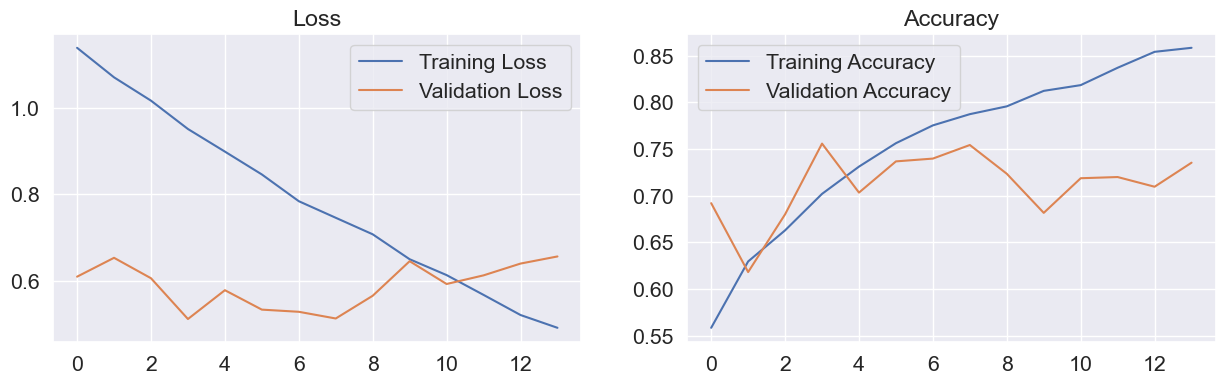

In [23]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Build the RNN model using LSTM layers
def RNN_model(input_shape, units=64, dropout_rate=0.5):
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True, input_shape=input_shape)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(units)),
        Dropout(dropout_rate),
        Dense(100, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape
input_shape = (train_features.shape[1], train_features.shape[2])  # (78, 64)

# Initialize the RNN model
model = RNN_model(input_shape=input_shape, units=64, dropout_rate=0.5)
model.summary()

# Early stopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    x=train_features,
    y=train_labels,
    validation_data=(test_features, test_labels),
    batch_size=256,
    epochs=50,
    validation_split=0.2,
    shuffle=True,
    class_weight={0: 1., 1: train_ratio},
    callbacks=[early_stop]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy/loss
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

In [24]:
# Predictions and confusion matrix
predictions = model.predict(test_features)
predictions = np.round(predictions)

score = np.array(model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step
Model performance on test set:	[ Loss: 1.2542	Accuracy: 0.7558 ]

Predictions: [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


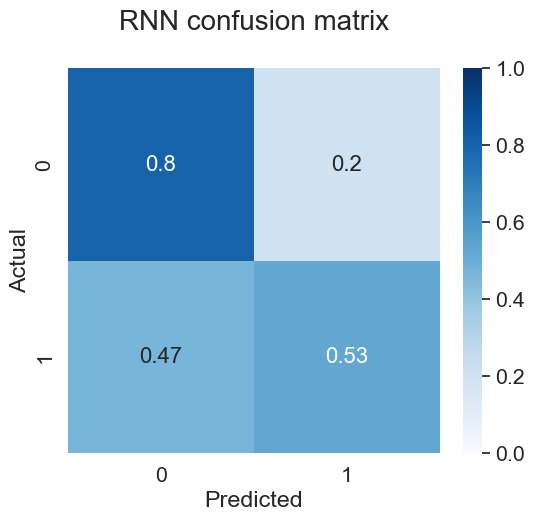

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Weighted confusion matrix (noP300: 80%, P300: 20%)
data_train = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data_train / np.full(data_train.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("RNN confusion matrix\n", fontsize=20)
plt.show()

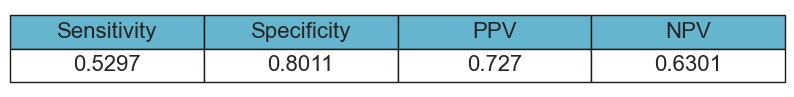

In [26]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp / (tp + fn), 4)  # Sensitivity
    spec = round(tn / (tn + fp), 4)  # Specificity
    ppv = round(tp / (tp + fp), 4)  # Positive Predicted Value
    npv = round(tn / (tn + fn), 4)  # Negative Predicted Value
    return {"Sensitivity": sens, "Specificity": spec, "PPV": ppv, "NPV": npv}


# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5, 1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())],
                 colLabels=list(metrics.keys()),
                 loc="center",
                 cellLoc="center",
                 colColours=["c"] * 4)
table.set_fontsize(16)
table.scale(2, 2)

plt.show()